# Dyna-$ Q $ and Dyna-$ Q+ $

## Introduction

In this homework, I'm exploring two model-based RL algorithms: **Dyna-$ Q $** and **Dyna-$ Q+ $**. Both are based on the experience replay cache holding quadruplets of the form *(current state, action, reward, next state)*. Instead of discarding an experience right after the update of the *Q-function*, Dyna reuses it over and over again as if it was actually happening. As a result, propagation of the reinforcement signal becomes more rapid (one doesn't have to wait for the next time the same *(state, action)* appearing in the real environment). Here I'm only considering the simplest case with deterministic rewards and transitions.

What differentiates Dyna-$ Q+ $ from Dyna-$ Q $ is a so-called **exploration bonus**. For each (state, action), Dyna-$ Q+ $ keeps track of the number $ n(\mbox{state}, \mbox{action}) $ of steps since the agent experienced that pair. If the agent is in the state $ s $ then the policy is to select the action $ a $ that maximizes $ Q(s, a) + \kappa \sqrt{n(s, a)} $, where $ \kappa $ is a small number. So the algorithm prefers to transition into states it visited long time ago.

In order to use the full advantage of planning, Dyna-$ Q+ $ uses the exploration bonux not only in the policy, but also in the update for the $ Q $-function:
$$ Q(s, a) \leftarrow R + \kappa \sqrt{n(s, a)} + \gamma \max_{b} Q(y, b) \, .$$

**NOTE:** Both in the original paper by [*Sutton (1991)*](https://webdocs.cs.ualberta.ca/~sutton/papers/sutton-91-SAB.pdf) and in the book, the authors mention that they further enhance Dyna-$ Q+ $ by permitting it hypothetically experience actions it has never tried before. Although, it sounds like a minor thing, in my experiments I found this trick to be crucial for the good performance of the algorithm (it actually performs substantially worse than Dyna-$ Q $ if the trick is not used).

## Some helper code

In [1]:
%matplotlib notebook

In [2]:
import copy
import gym
import itertools
import matplotlib
import numpy as np
import os
import pandas as pd
import random
import sys
import time

from collections import defaultdict, namedtuple
from functools import partial
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from tqdm import tqdm

from lib.algos.utils import ConstantLearningRate, greedy_policy, epsilon_greedy_policy
from lib.envs.gridworld import GridworldEnv
from lib.plotting import EpisodeStats

plt.style.use('ggplot')

## Implementation of the algorithms


In [27]:
from IPython.display import clear_output

class DebugCallback(object):
    def __init__(self, env):
        self.fig, self.ax = plt.subplots(1, 3)
        self.mpl_E = self.ax[0].imshow(np.ones((env.nrow, env.ncol, 3)))
        self.ax[0].grid('off')
        self.ax[0].set_title('Environment')
        self.mpl_Q = self.ax[1].imshow(np.ones((env.nrow, env.ncol)), vmin=0.0, vmax=1.0, cmap=plt.cm.viridis)
        self.ax[1].grid('off')
        self.ax[1].set_title('Q')
        self.mpl_L = self.ax[2].imshow(np.ones((env.nrow, env.ncol)), vmin=0.0, vmax=1.0, cmap=plt.cm.viridis)
        self.ax[2].grid('off')
        self.ax[2].set_title('Last seen')

    def __call__(self, env, step, Q, last_seen=None, show_after=3000):
        if step < show_after:
            return

        # Render environment.
        E_viz = env.get_image()

        # Render Q-function.
        Q_viz = np.zeros(env.nrow * env.ncol)
        for s in xrange(len(Q_viz)):
            Q_viz[s] = np.max(Q[s])
        Q_viz -= Q_viz.min()
        Q_viz /= Q_viz.max()
        Q_viz = Q_viz.reshape((env.nrow, env.ncol))

        # Render last seen array.
        if last_seen is not None:
            L_viz = np.zeros(env.nrow * env.ncol)
            for s in xrange(len(L_viz)):
                L_viz[s] = max(np.max(last_seen[s]), 0.0)
            L_viz -= L_viz.min()
            L_viz /= L_viz.max()
            L_viz = L_viz.reshape((env.nrow, env.ncol))

        self.mpl_E.set_array(E_viz)
        self.mpl_Q.set_array(Q_viz)
        if last_seen is not None:
            self.mpl_L.set_array(L_viz)

        self.fig.show()
        self.fig.canvas.draw()

        time.sleep(0.05)

In [28]:
def dyna_q(env, num_episodes, epsilon=0.1, discount_factor=0.95, alpha=ConstantLearningRate(0.1),
           planning_steps=10, use_greedy_policy=False, use_plus=False,
           exploration_reward_multiplier=0.001, debug_callback=None):
    # We start with an all-zero Q-function estimate.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keep track of useful statistics.
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    rewards = []
    
    # Define behavior policy w.r.t. the Q estimate.
    if use_greedy_policy:
        policy = partial(greedy_policy, Q=Q, num_actions=env.action_space.n)
    else:
        policy = partial(epsilon_greedy_policy, Q=Q, epsilon=epsilon, num_actions=env.action_space.n)
    
    # Model is just a dictionary.
    model = {}
    
    if use_plus:
        # A memory structure to keep track of how stale the (state, action) is.
        last_seen = np.zeros((env.observation_space.n, env.action_space.n))
        
        def update_last_seen(state, action):
            last_seen[:] += 1
            last_seen[state][action] = 0
    else:
        last_seen = None

    if use_plus:
        # Add fictive experiences to the memory.
        for state in xrange(env.observation_space.n):
            for action in xrange(env.action_space.n):
                model[(state, action)] = (0, state)
                last_seen[state][action] = 0
    
    # Run episodes.
    for episode_idx in xrange(num_episodes):  
        state = env.reset()
  
        for t in itertools.count():
        
            def update_q(state, action, reward, next_state):
                best_action = np.argmax(Q[next_state])
                Q[state][action] += alpha(state, action) * (reward +
                                                            discount_factor * Q[next_state][best_action] - 
                                                            Q[state][action])
            
            #############################################################
            # Direct reinforcement learning step.
            #############################################################
            # Act according to the behavior policy.
            if use_plus:
                # Use modified Q to account for staleness of (state, action).
                old_Q_state = Q[state]
                staleness = np.maximum(last_seen[state], 0.0)
                Q[state] = Q[state] + exploration_reward_multiplier * np.sqrt(staleness)
                action_probs = policy(state)
                Q[state] = old_Q_state
            else:
                action_probs = policy(state)
            action = np.random.choice(env.action_space.n, p=action_probs)
            next_state, reward, done, _ = env.step(action)
            update_q(state, action, reward, next_state)
            
            if debug_callback is not None:
                debug_callback(env, len(rewards), Q, last_seen)
            
            #############################################################
            # Model learning step.
            #############################################################
            if use_plus:
                # Add fictive observations to the model.
                if (state, action) not in model:
                    for i in xrange(env.action_space.n):
                        model[(state, i)] = (0, state)
                # Update staleness of (state, action) pairs.
                update_last_seen(state, action)
            # Add actual observation.
            model[(state, action)] = (reward, next_state)
            
            #############################################################
            # Planning steps.
            #############################################################
            for i in xrange(planning_steps):
                if len(model) == 0:
                    break
                sim_state, sim_action = random.choice(model.keys())
                sim_reward, sim_next_state = model[(sim_state, sim_action)]
                if use_plus:
                    # Account for staleness of the (state, action) pair.
                    staleness = max(last_seen[sim_state][sim_action], 0.0)
                    sim_reward += exploration_reward_multiplier * np.sqrt(staleness)
                update_q(sim_state, sim_action, sim_reward, sim_next_state)
            
            # Update reward statistics.
            stats.episode_rewards[episode_idx] += reward
            rewards.append(reward)
            
            # Transition into the next state.
            state = next_state
            if done:
                stats.episode_lengths[episode_idx] = t
                break
               
    return Q, stats, rewards

## Maze experiments

One of the problems with the model-based approach is that it tends underperform in changing environments. This is due to the model dynamics used in the planning process becoming incorrect. In order to illustrate the problem, I'm going to reproduce two experiments from [*Sutton (1991)*](https://webdocs.cs.ualberta.ca/~sutton/papers/sutton-91-SAB.pdf), namely, **blocking** and **shortcut** mazes. In both cases, the hyperparameters are taken from the paper. Behavior policy is chosen to be greedy.

In [ ]:
from gym.envs.toy_text import discrete

class SwitchingEnv(discrete.DiscreteEnv):
    '''A meta-environment that switches between two given environments after a certain number of steps.'''
    def __init__(self, env1, env2, switch_after=1000):
        self.env1 = env1
        self.env2 = env2
        self.switch_after = switch_after
        self.reset_switch()
        
    @property
    def nrow(self):
        return self.cur_env.nrow
    
    @property
    def ncol(self):
        return self.cur_env.ncol
        
    @property
    def action_space(self):
        return self.cur_env.action_space
    
    @property
    def observation_space(self):
        return self.cur_env.observation_space
        
    def step(self, *args, **kwargs):
        self.num_steps += 1
        next_state, reward, done, _ = self.cur_env.step(*args, **kwargs)
        if self.num_steps == self.switch_after:
            self.cur_env = self.env2
            done = True            
        return next_state, reward, done, _
    
    def reset(self):
        return self.cur_env.reset()
    
    def reset_switch(self):
        self.cur_env = env1
        self.num_steps = 0
        
    def get_image(self, *args, **kwargs):
        return self.cur_env.get_image(*args, **kwargs)
    
    def render(self, *args, **kwargs):
        self.cur_env.render(*args, **kwargs)

### Blocking maze

In the **blocking** problem, after the agent has learned the optimal path from start to goal (I assume, **1000** steps is enough), a new barrier is added that blocks the optimal path.

In [32]:
map1 = [
    "ooooooooG",
    "ooooooooo",
    "ooooooooo",
    "WWWWWWWWo",
    "ooooooooo",
    "oooSooooo",
]
env1 = GridworldEnv(map1)

map2 = [
    "ooooooooG",
    "ooooooooo",
    "ooooooooo",
    "oWWWWWWWW",
    "ooooooooo",
    "oooSooooo",
]
env2 = GridworldEnv(map2)

env = SwitchingEnv(env1, env2, switch_after=1000)

In [33]:
num_trials = 40
num_episodes = 100
epsilon = 0.1
discount_factor = 0.9
planning_steps = 10
alpha = 0.5
exploration_reward_multiplier = 0.001

configs = {
    'algo': ['no_plan', 'dyna_q', 'dyna_q_plus']
}

def job(seed, algo):
    np.random.seed(seed=seed)
    random.seed(seed)
    env.reset_switch()
    if algo == 'no_plan':
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=0,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha))
    elif algo == 'dyna_q':
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=planning_steps,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha))
    else:  # 'dyna_q_plus'
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=planning_steps,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha),
                               use_plus=True, exploration_reward_multiplier=exploration_reward_multiplier)
    return rewards

for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}'.format(**config)
    filename = 'results/{}_block.npy'.format(name)
    if os.path.exists(filename):
        continue
    rewards = Parallel(n_jobs=8)(
        [delayed(job)(s, **config) for s in np.random.randint(0, num_trials * 1000, num_trials)])
    np.save(filename, rewards)

In [34]:
all_mean_cumulative_rewards = {}
for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}'.format(**config)
    filename = 'results/{}_block.npy'.format(name)
    rewards = np.load(filename)
    min_length = min(min(len(x) for x in rewards), 2000)
    rewards = np.array([x[: min_length] for x in rewards])
    mean_cumulative_rewards = np.mean(np.cumsum(rewards, axis=1), axis=0)
    all_mean_cumulative_rewards[config['algo']] = mean_cumulative_rewards

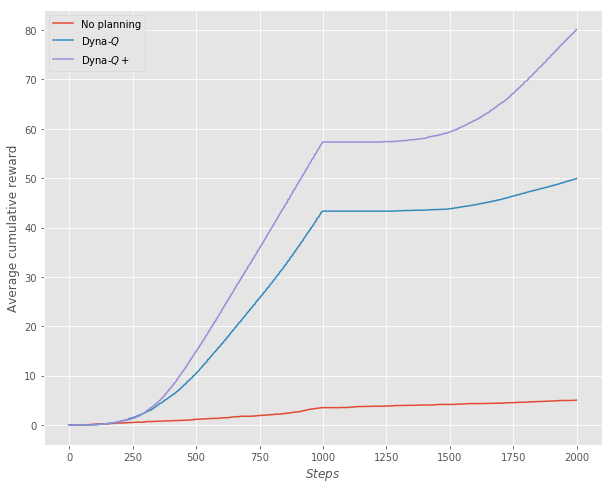

In [35]:
fig = plt.figure(figsize=(10, 8))
    
plt.plot(all_mean_cumulative_rewards['no_plan'], label='No planning')
plt.plot(all_mean_cumulative_rewards['dyna_q'], label='Dyna-$ Q $')
plt.plot(all_mean_cumulative_rewards['dyna_q_plus'], label='Dyna-$ Q\!+ $')

plt.xlabel('$ Steps $')
plt.ylabel("Average cumulative reward")
plt.legend()

plt.show(fig)

As we can see, both Dyna algorithms outperformed the non-planning agent and found the long path to the goal. Interestingly, Dyna-$ Q+ $ does a substantially better job. I suspect this is due to the presence of the exploration bonus. Indeed, Dyna-$ Q $'s exploration is only driven by the $ Q $-function which does not provide much information about the optimal path in the very beginning of the training process. It might lead to the situation when the agent spends too much time doing random actions in the dead-end part of the maze. Dyna-$ Q+ $, on the other hand, is encouraged to visit the states which it has never been to or visited long time ago. That results in the agent trying to visit all the states in the vicinity of the start state at least once as quickly as possible. Obviously, one of those state is right next to the escape, and therefore, the Dyna-$ Q+ $ spends less time trying to reach the upper part of the maze. 

### Shortcut maze

In this experiment, after the algorithms found the optimal policy, a shortcut to the goal is added (one of the barriers is removed). This setting is a bit trickier for Dyna-$ Q $ as the original optimal policy stays a valid strategy for reaching the destination. 

In [31]:
map1 = [
    "ooooooooG",
    "ooooooooo",
    "ooooooooo",
    "oWWWWWWWW",
    "ooooooooo",
    "oooSooooo",
]
env1 = GridworldEnv(map1)

map2 = [
    "ooooooooG",
    "ooooooooo",
    "ooooooooo",
    "oWWWWWWWo",
    "ooooooooo",
    "oooSooooo",
]
env2 = GridworldEnv(map2)

env = SwitchingEnv(env1, env2, switch_after=3000)

In [29]:
num_trials = 40
num_episodes = 300
epsilon = 0.1
discount_factor = 0.9
planning_steps = 10
alpha = 0.5
exploration_reward_multiplier = 0.001

configs = {
    'algo': ['no_plan', 'dyna_q', 'dyna_q_plus']
}

def job(seed, algo):
    np.random.seed(seed=seed)
    random.seed(seed)
    env.reset_switch()
    if algo == 'no_plan':
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=0,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha))
    elif algo == 'dyna_q':
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=planning_steps,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha),
                               use_greedy_policy=True)
    else:  # 'dyna_q_plus'
        _, _, rewards = dyna_q(env, num_episodes, epsilon=epsilon, planning_steps=planning_steps,
                               discount_factor=discount_factor, alpha=ConstantLearningRate(alpha),
                               use_plus=True, exploration_reward_multiplier=exploration_reward_multiplier,
                               use_greedy_policy=True)
    return rewards

for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}'.format(**config)
    filename = 'results/{}_short.npy'.format(name)
    if os.path.exists(filename):
        continue
    rewards = Parallel(n_jobs=8)(
        [delayed(job)(s, **config) for s in np.random.randint(0, num_trials * 1000, num_trials)])
    np.save(filename, rewards)

In [30]:
all_mean_cumulative_rewards = {}
for v in itertools.product(*configs.values()):
    config = dict(zip(configs.keys(), v))
    name = '{algo}'.format(**config)
    filename = 'results/{}_short.npy'.format(name)
    rewards = np.load(filename)
    min_length = min(min(len(x) for x in rewards), 6000)
    rewards = np.array([x[: min_length] for x in rewards])
    mean_cumulative_rewards = np.mean(np.cumsum(rewards, axis=1), axis=0)
    all_mean_cumulative_rewards[config['algo']] = mean_cumulative_rewards

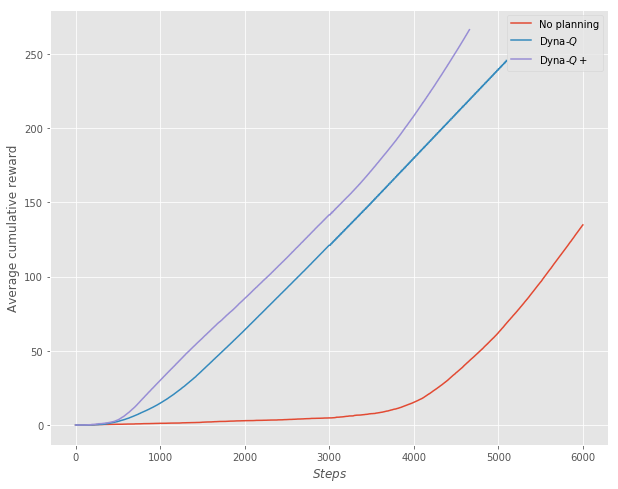

In [31]:
fig = plt.figure(figsize=(10, 8))
    
plt.plot(all_mean_cumulative_rewards['no_plan'], label='No planning')
plt.plot(all_mean_cumulative_rewards['dyna_q'], label='Dyna-$ Q $')
plt.plot(all_mean_cumulative_rewards['dyna_q_plus'], label='Dyna-$ Q\!+ $')

plt.xlabel('$ Steps $')
plt.ylabel("Average cumulative reward")
plt.legend()

plt.show(fig)

As we can see, in this experiment, Dyna-$ Q $ fails to find the shortcut and keeps using the long path the goal, while both Dyna-$ Q+ $ and the non-planning agent discovered the optimal trajectory. That is to be expected as there is no incentive for Dyna-$ Q $ to change the strategy once it has found *some* way to reach the goal (**reminder:** behavior policy is greedy). A close inspection of the curves above reveals that the difference between Dyna-$ Q+ $ and Dyna-$ Q $ narrowed slightly over the first part of the experiment. I think this is due to exploratory behavior of the former algorithm — it keeps visiting the dead-end from time to time despite the fact that the optimal path has been found already.

### Live demo of Dyna-$ Q+ $

In [ ]:
env.reset_switch()
_, _, rewards = dyna_q(env, 300, epsilon=0.1, planning_steps=10, discount_factor=0.9,
                       alpha=ConstantLearningRate(0.5), use_greedy_policy=True,
                       use_plus=True, debug_callback=DebugCallback(env))